In [1]:
import numpy as np
import numpy.random as rnd

import pandas as pd

import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt

In [2]:
def powerlaw(t, exponent, x_min, x_max):
    """returns (normalization)t^{-exponent}"""
    area = (np.power(x_max, 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return np.power(t, -exponent)/area
    
# not used, but useful to understand how the loglog_powerlaw is written
def log_powerlaw(t, exponent, x_min, x_max):
    area = (np.power(x_max, 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return -exponent*np.log(t) - np.log(area)

def loglog_powerlaw(log_t, exponent, x_min, x_max):
    """Linear function of log(t)"""
    area = (np.power(x_max, 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return -exponent*log_t - np.log(area)

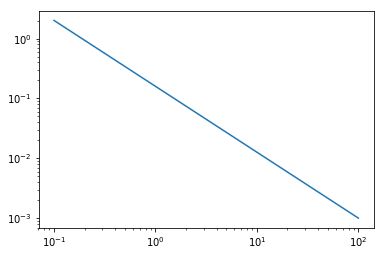

In [3]:
# check if the power law works

t_axis = np.linspace(0.1,100, 10000)
plt.plot(t_axis, powerlaw(t_axis, 1.1, 0.1, 100))
plt.xscale('log')
plt.yscale('log')

In [4]:
# adding also an exponential cut-off: P_cut(t) = (norm)t^{-p}*exp{-t/t_cut}

def powerlaw_cut(x, exponent, x_min, x_max, x_cut, strength):
    """returns P_cut(t) = (norm)t^{-p}*exp{-t/t_cut}"""
    # just modify the area formula in order to have an approximate normalization between x_min and x_cut 
    # (if x_cut < x_max, as it should be)
    area = (np.power(min(x_max,x_cut), 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return np.power(x, -exponent)* np.exp(-strength*x/x_cut)/area

def loglog_powerlaw_cut(log_x, exponent, x_min, x_max,x_cut, strength):
    """Linear function of log(x)"""
    area = (np.power(min(x_max,x_cut), 1-exponent) - np.power(x_min, 1-exponent))/(1-exponent)
    return -exponent*log_x - strength*np.exp(log_x - np.log(x_cut)) - np.log(area)

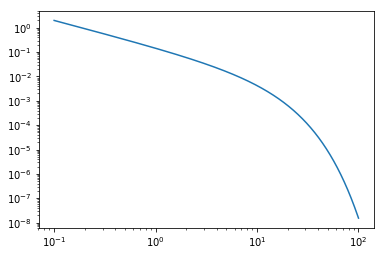

In [5]:
# check if the power law with cut-off works

t_axis = np.linspace(0.1,100, 10000)
plt.plot(t_axis, powerlaw_cut(t_axis, 1.1, 0.1, 100, 90, 10))
plt.xscale('log')
plt.yscale('log')

In [6]:
def generate_powerlaw(n_samples, exponent, x_min, x_max):
    P_x_min = powerlaw(x_min, exponent, x_min, x_max)
    P_x_max = powerlaw(x_max, exponent, x_min, x_max)
    
    #compute the extremes of the two axes in log-log space
    a = np.log(x_min)
    b = np.log(x_max)
    c = np.log(P_x_min)
    d = np.log(P_x_max)
    
    log_samples = np.zeros(n_samples)
    
    i = 0
    while (i < n_samples):
        
        #Montecarlo method for generating a powerlaw distribution in the rectangle [a,b]x[c,d]
        
        # u random variable in [a,b] ; u = log(t)
        u = (b - a) * rnd.random() + a
        # v random variable in [c,d] ; v = lot(P(t))
        v = (d - c) * rnd.random() + c

        if loglog_powerlaw(u, exponent, x_min, x_max) < v:
            
            # samples are random variables of log(t) with t distibuted as the given power law
            log_samples[i] = u
            i = i + 1
            
        else:
            continue
    
    samples = np.exp(log_samples)
    return samples

In [7]:
def generate_powerlaw_with_cutoff(n_samples, exponent, x_min, x_max, x_cut, strength):
    P_x_min = powerlaw(x_min, exponent, x_min, x_max)
    P_x_max = powerlaw(x_max, exponent, x_min, x_max)
    
    #compute the extremes of the two axes in log-log space
    a = np.log(x_min)
    b = np.log(x_max)
    c = np.log(P_x_min)
    d = np.log(P_x_max)
    
    log_samples = np.zeros(n_samples)
    
    i = 0
    while (i < n_samples):
        
        #Montecarlo method for generating a powerlaw distribution in the rectangle [a,b]x[c,d]
        
        # u random variable in [a,b] ; u = log(t)
        u = (b - a) * rnd.random() + a
        # v random variable in [c,d] ; v = lot(P(t))
        v = (d - c) * rnd.random() + c

        if loglog_powerlaw_cut(u, exponent, x_min, x_max, x_cut, strength) < v:
            
            # samples are random variables of log(t) with t distibuted as the given power law
            log_samples[i] = u
            i = i + 1
            
        else:
            continue
    
    samples = np.exp(log_samples)
    return samples

In [8]:
def binning(x, rescaling = False, density = False):
    
    """Binning for power laws distributions.
        x = entries generated from a power law."""
    
    # x must have streactly positive values; x isn't normalized in general
    x = x[x>0]
    if rescaling == True:
        x = x/x.max()
    
    # empirical method to get a good amount of bins (min 5), depending on the number of samples
    bin_extremes_number = max( min( int( np.log(len(x)) ) , 17), 9) 
    
    bin_extremes = np.exp(np.linspace(np.log(x.min()), np.log(x.max()), bin_extremes_number))
    
    widths = bin_extremes[1:] - bin_extremes[:-1]
    centers = (bin_extremes[1:] + bin_extremes[:-1])/2
    
    freq, _, _ = plt.hist(x, bins=bin_extremes)
    plt.close()
    
    # weights(bin_center) = Prob(bin_center) if normalized
    weights = freq/widths
    sigma_weights = np.sqrt(freq)/widths
    
    # merging of the first two bins until we get that the first bin represents the max of the PDF
    while weights[0] < weights[1]:
        print('Merging first and second bins.')
        #this is done by removing the second extreme, thus the first bin becomes the one between 0 and 2
        bin_extremes = np.concatenate(([bin_extremes[0]], bin_extremes[2:] ))
        widths = bin_extremes[1:] - bin_extremes[:-1]
        centers = (bin_extremes[1:] + bin_extremes[:-1])/2

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
    
    if density == True:
        #returns normalized weights (with rescaled errors) so that the area of the histogram is 1
        area = np.sum(weights*widths)
        weights = weights / area
        sigma_weights = sigma_weights/area
    
    return bin_extremes, widths, centers, freq, weights, sigma_weights   

In [53]:
def binning2(x, quantile = 20, rescaling = False, density = False):
    
    """Binning for power laws distributions.
        x = entries generated from a power law."""
    
    # x must have streactly positive values; x isn't normalized in general
    x = x[x>0]
    if rescaling == True:
        x = x/x.max()
        
    x.sort()
    # empirical method to get a good amount of bins (min 8), depending on the number of samples
    bin_extremes_number = max( min( int( np.log(len(x))*2 ) , 17), 9) 
    #bin_extremes_number = max( min( int( np.log(len(x)) ) , 17), 9) 
    print('Bin extremes number chosen: ', bin_extremes_number )
    #first_quantile = x[int(x.shape[0]*(1/quantile))]
    first_quantile = x[int(x.shape[0]*(1/bin_extremes_number))]
    print('First quantile: ', first_quantile)
    bin_extremes = np.logspace(np.log10(first_quantile), np.log10(x.max()), bin_extremes_number)
    bin_extremes = np.concatenate((np.array([0]), bin_extremes))

    widths = bin_extremes[1:] - bin_extremes[:-1]
    centers = (bin_extremes[1:] + bin_extremes[:-1])/2
    
    freq, _, _ = plt.hist(x, bins=bin_extremes)
    plt.close()
    
    # weights(bin_center) = Prob(bin_center) if normalized
    weights = freq/widths
    sigma_weights = np.sqrt(freq)/widths
    
    # merging of the first two bins until we get that the first bin represents the max of the PDF
    while weights[0] < weights[1]:
        print('Merging first and second bins.')
        #this is done by removing the second extreme, thus the first bin becomes the one between 0 and 2
        bin_extremes = np.concatenate(([bin_extremes[0]], bin_extremes[2:] ))
        widths = bin_extremes[1:] - bin_extremes[:-1]
        centers = (bin_extremes[1:] + bin_extremes[:-1])/2

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
        
    # adding also the merging of empty bins with the one on the left
    # rewrite it in a better form
    mask = (freq != np.zeros(len(freq)))
    flag = np.all(mask)
    print('All frequencies are non-zero : ', flag)
    # should enter in the while loop only in there is at least one bin without counts in it
    
    while flag == False:
        print('Entered in the while loop')
        print('Original frequencies: ', freq)
        for i in range(1,len(freq)):
            if freq[i] == 0:
                print('Merging bin {} (empty) with bin {}.'.format(i,i-1))
                # bin extremes should be of length len(freq) + 1
                # notice that bin_extremes[i] corresponds to the right border of bin[i-1]
                # bin_extremes[:i] excludes the bin_extreme[i] !
                bin_extremes = np.concatenate((bin_extremes[:i], bin_extremes[i+1:] ))
                widths = bin_extremes[1:] - bin_extremes[:-1]
                centers = (bin_extremes[1:] + bin_extremes[:-1])/2
                # call a break of the for because the len frequence changes and can result in index errors
                break
                
        # update of the frequencies

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
        
        mask = (freq != np.zeros(len(freq)))
        flag = np.all(mask)
 
    if density == True:
        #returns normalized weights (with rescaled errors) so that the area of the histogram is 1
        area = np.sum(weights*widths)
        weights = weights / area
        sigma_weights = sigma_weights/area
    
    return bin_extremes, widths, centers, freq, weights, sigma_weights   

In [57]:
def loglog_fitting(x, y, skip_initial_pt = 1, cut_off = False ):
    from scipy import optimize
    
    def linear_f(x, p, q):
        return p*x+q

    x = x[skip_initial_pt:]

    y = y[skip_initial_pt:]
    
    if cut_off == False:
        params, cov = optimize.curve_fit(linear_f, x, y)
        [p,q] = params
        return p, q, cov
    
    else:
        #notice that we are already working without considering the first skip_initial_pt points
        mean_squared_res = []    
        predicted_squared_res = []
        
        # P is the number of points considered for the fit, used for testing whether the point P+1 is alligned
        # with them or not; the likelihood of not being alligned is given by the ratio between 
        # the predicted squared residual of point P+1 (based on the fit on the previous P points) 
        # and the mean squared residual computed for the P points 

        #for P in range(3,len(x)):
        # try with 4
        for P in range(5,len(x)):
            params, cov = optimize.curve_fit(linear_f, x[:P], y[:P])
            [p,q] = params

            squared_residuals = np.power(y[:P] - linear_f(x[:P], *params),2)
            mean_squared_res.append(squared_residuals.mean())
            
            next_pt_squared_res = np.power(y[P] - linear_f(x[P], *params),2) 
            predicted_squared_res.append(next_pt_squared_res)
            
        predicted_squared_res = np.array(predicted_squared_res)
        mean_squared_res = np.array(mean_squared_res)
        predicted_vs_mean_ratio = predicted_squared_res/mean_squared_res
        predicted_vs_mean_ratio_norm = predicted_vs_mean_ratio/predicted_vs_mean_ratio.max()
    
        # The index of the array predicted_vs_mean_ratio_norm is shifted by 3 positions, meaning that we consider
        # as the maximal number of alligned points the one corresponding to the index of the max of 
        # predicted_vs_mean_ratio_norm + 3 = good_points. 
        
        #indexes = np.arange(3,len(x))
        indexes = np.arange(5,len(x))
        max_index = indexes[predicted_vs_mean_ratio_norm == predicted_vs_mean_ratio_norm.max()]
        good_points = max_index[0]
        print('Good points {} out of {}'.format(good_points, len(x)))
        # Then the cut-off is estimated as x_cut = (x[good_points]+ x[good_points+1])/2
        if good_points < len(x):
            # the -1 shift at the index is because the index numeration starts at 0
            x_cut = (x[good_points-1]+ x[good_points])/2
        else:
            print('ATTENTION: all points seem alligned.')
            print('x_cut set to the value of the last point.')
            x_cut = x[-1]
            
        params, cov = optimize.curve_fit(linear_f, x[:good_points], y[:good_points])
        [p,q] = params
        
        return p, q, cov, x_cut
        
def linear_f(x, p, q):
        return p*x+q

In [43]:
def plot_powerlaw_hist(x, quantile = 20, rescaling = False, density = False, **kwargs):
    
    bin_extremes, widths, centers, freq, weights, sigma_weights = binning2(x, quantile, rescaling, density)
    bin_number = len(centers)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
        
    ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
    ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized waiting times', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(x)))
    
    # now we need to fit the power law in the log-log space, eventually identifying the points before the cut-off
    # this should work automatically both for the case rescaling = True or False (if True, x is in [0,1]) 
    # and for the case density = True or False (if True, the area of the histogram is normalized to 1 
    # and the weights are rescaled so that np.sum(weights*bin_widths) = 1)
    log_x = np.log(centers)
    log_w = np.log(weights)
    
    # the idea is to write a function that as a default just fits the (log_x,log_w) with a linear function 
    # log_w = p*log_x + q and has 2 flags: one for excluding skip_initial_pt points (set to 1 for default because
    # the first bin is always problematic) and another one to signal that we expect a cut-off at the right side of the
    # distribution (i.e. the tail) and we want to stop fitting just before the cut-off.
    # we want as a return the parameters p and q with their covariance matrix (that is the default return of 
    # scipy curve_fit) and, if the cut_off flag is True, also the estimate cut-off (rescaled or not depending on the 
    # setting passed before)
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
             p, q, cov, log_x_cut = loglog_fitting(log_x, log_w, **kwargs)
    else:
        p, q, cov = loglog_fitting(log_x, log_w, **kwargs)
    
    # those errors are wrong!
    #y_errors = 1./np.sqrt(weights)
    #should be
    y_errors = sigma_weights/weights
    
    ax2.errorbar(log_x, log_w, yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(log_x, linear_f(log_x, p, q), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(p,1),round(q,1)))
    ax2.legend()
    ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    plt.show()
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
             return p, q, cov, log_x_cut
    else:
        return p, q, cov 

Bin extremes number chosen:  9
First quantile:  0.15183686833134147


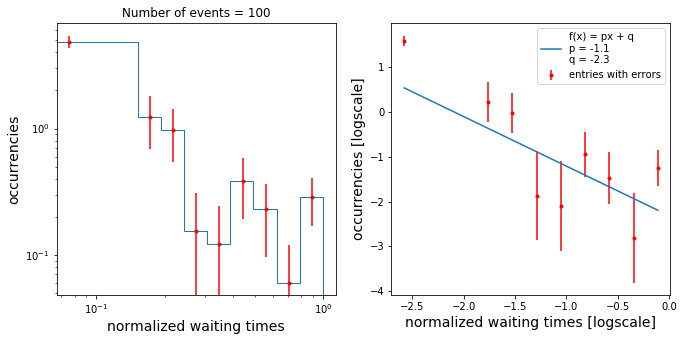

Bin extremes number chosen:  9
First quantile:  8.790879884680244e-05


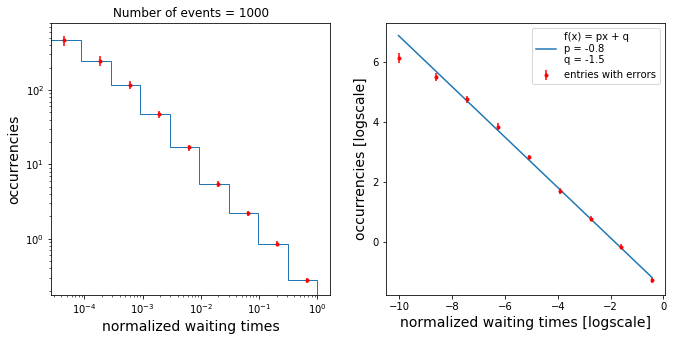

Bin extremes number chosen:  9
First quantile:  0.0024018807744954802


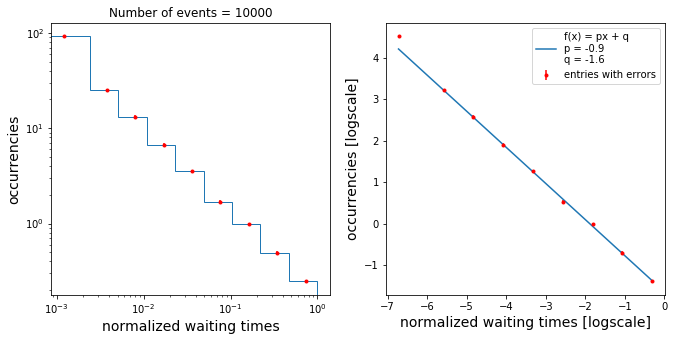

Bin extremes number chosen:  11
First quantile:  0.00937984523243424


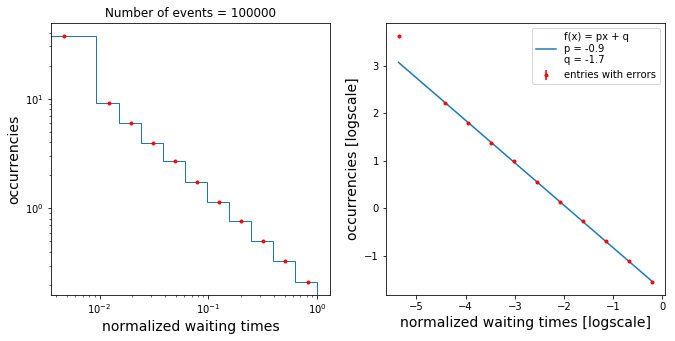

Bin extremes number chosen:  13
First quantile:  0.022248055812747407


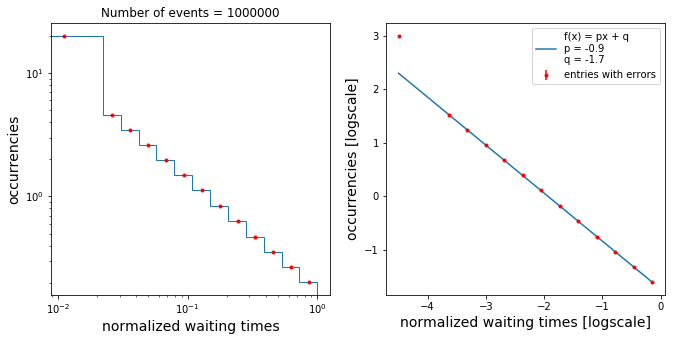

In [23]:
Ns = [10**i for i in range(2,7)]
for N in Ns:
    rnd_times = generate_powerlaw(n_samples = N, exponent = 1.1, x_min = 1, x_max = 100000)
    plot_powerlaw_hist(rnd_times, rescaling = True, density = True)

Bin extremes number chosen:  9
First quantile:  0.6832844754750266
All frequencies are non-zero :  True
Good points 3 out of 8


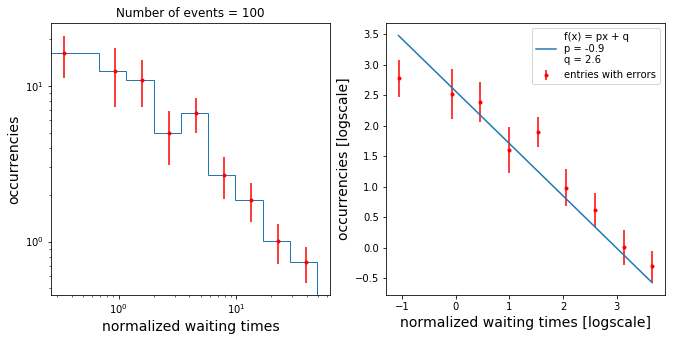

Bin extremes number chosen:  9
First quantile:  0.6791065597466459
Merging first and second bins.
All frequencies are non-zero :  True
Good points 3 out of 7


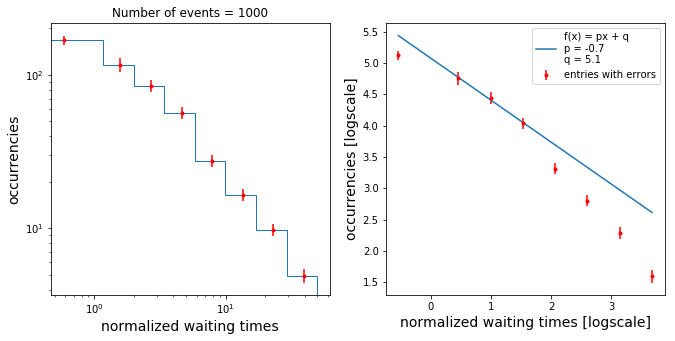

Bin extremes number chosen:  9
First quantile:  0.7155437143618453
Merging first and second bins.
All frequencies are non-zero :  True
Good points 3 out of 7


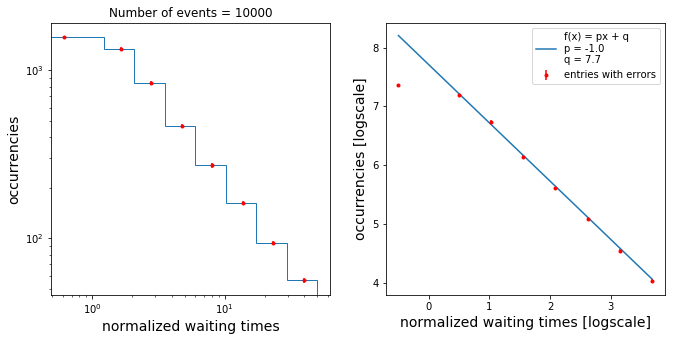

Bin extremes number chosen:  11
First quantile:  0.6086051632032726
Merging first and second bins.
All frequencies are non-zero :  True
Good points 3 out of 9


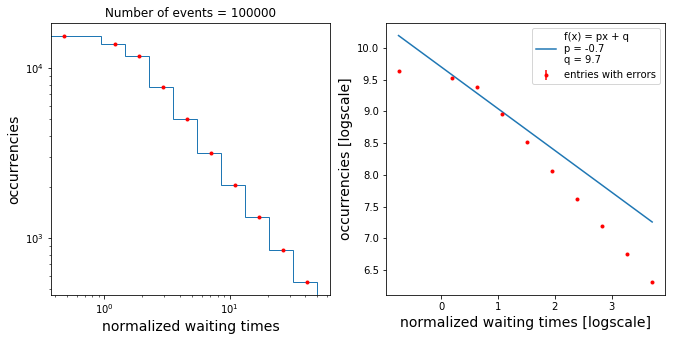

Bin extremes number chosen:  13
First quantile:  0.5285122765752904
Merging first and second bins.
All frequencies are non-zero :  True
Good points 3 out of 11


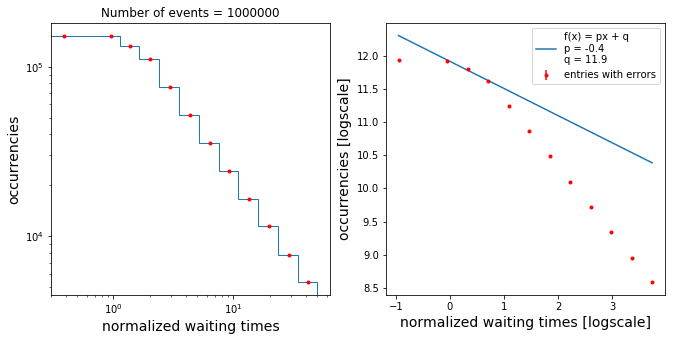

In [52]:
Ns = [10**i for i in range(2,7)]
for N in Ns:
    rnd_times = generate_powerlaw_with_cutoff(n_samples = N, exponent = 1.1, 
                                              x_min = 0.1, x_max = 50, x_cut = 50, strength = 100)
    # this parametrization of the cutoff isn't much convincing
    plot_powerlaw_hist(rnd_times, cut_off = True)

## Exploring ways to detect cut-off in log-log space

In [ ]:
def linear_f(x, p, q):
        return p*x+q

In [ ]:
x = np.linspace(0,10,20)
x0 = 5
p1 = -1
q1 = 6
p2 = -3
q2 = (p1-p2)*x0 + q1
x1 = x[x < x0]
x2 = x[x >= x0]
y1 = linear_f(x1, p1, q1)
y2 = linear_f(x2, p2, q2)
y = np.concatenate((y1,y2))
#adding some noise to study a non-ideal case
noise_strength = 0.2
noise = noise_strength * rnd.randn(len(y))
y_empirical = y + noise
plt.plot(x,y_empirical, '.')
plt.show()

In [ ]:
# now that we have our "cut-off" we want to detect the first point of the second line 
# (actually being continuous we will get the second, because the first one is also on the first line)

pearson_r = []
for i in range(3,len(x)):
    r, p_value = stats.pearsonr(x[:i], y_empirical[:i])
    pearson_r.append(r)
    print("r = %.4f for %.0f points"%(r,i))

plt.plot(np.array(pearson_r)*(-1), 'rx')
plt.show()
# this method doesn't work very well...

In [ ]:
# predictive method with residuals:
# compute the mean of absolute residuals (one can try also with the squared ones) and if 
# the predicted residual for the point next to the ones considered is more than 3 times the mean that point
# is considered the cut-off (we could also quantify how much is plausible that a point is the cut-off)

# remember that we work with the dataset (x, y_empirical) and the cut-off should be found at x = 5
mean_squared_residuals = []
mean_absolute_residuals = []
predicted_squared_residuals = []
predicted_absolute_residuals = []

from scipy import optimize

for points in range(3,len(x)):
    params, cov = optimize.curve_fit(linear_f, x[:points], y_empirical[:points])
    [p,q] = params
    
    squared_residuals = np.power(y_empirical[:points] - linear_f(x[:points], *params),2)
    absolute_residuals = np.abs(y_empirical[:points] - linear_f(x[:points], *params))
    
    mean_squared_residuals.append(squared_residuals.mean())
    mean_absolute_residuals.append(absolute_residuals.mean())
    
    next_pt_squared_res = np.power(y_empirical[points] - linear_f(x[points], *params),2)
    next_pt_absolute_res = np.abs(y_empirical[points] - linear_f(x[points], *params))
    
    predicted_squared_residuals.append(next_pt_squared_res)
    predicted_absolute_residuals.append(next_pt_absolute_res)

plt.plot(predicted_squared_residuals, 'rx', label = 'next_pt_squared_res')
plt.plot(mean_squared_residuals, '.b', label = 'expected squared res')
plt.xlabel('index i for i+3 points considered', fontsize = 14)
plt.legend()
plt.show()
                    
plt.plot(predicted_absolute_residuals, 'rx', label = 'next_pt_absolute_res')
plt.plot(mean_absolute_residuals, '.b', label = 'expected absolute res')
plt.xlabel('index i for i+3 points considered', fontsize = 14)
plt.legend()
plt.show()

predicted_squared_residuals = np.array(predicted_squared_residuals)
mean_squared_residuals = np.array(mean_squared_residuals)
predicted_vs_mean_ratio = predicted_squared_residuals/mean_squared_residuals
predicted_vs_mean_ratio_norm = predicted_vs_mean_ratio/predicted_vs_mean_ratio.max()

indexes = [i for i in range(3, len(x))]
plt.plot(indexes, predicted_vs_mean_ratio_norm, 'o' )
plt.title('predicted vs mean squared residual ratio')
plt.show()


The max of the ratio between the predicted squared residual of point P+1 (based on the fit on the previous P points) and the mean squared residual computed for the P points is a good indicator of the cutoff. 

In fact the first one out of the line will be the one with the greatest ratio, because the mean squared residual is very low for the previous points (that are alligned), whereas we expect that for the second point out of line the predicted squared residual is still high, but the mean squared residual has increased due to the fact that we have included the first point out of line in the fit. 
Consequently the ratio will be smaller than for the first point out of line. The cut-off can be taken as the middle point between the "pivot" point and the first point out of line. 

In [ ]:
def pass_kwargs(**kwargs):
    if 'density' in kwargs:
        print(kwargs)
    # notice that a function cannot receive a keyword argument that isn't between the one that are definded within 
    # the function itself
    f1(**kwargs)
    
def f1(a = 1):
    print('Hello')

In [ ]:
pass_kwargs(a = 2)

## Now we try it with the real dataset

In [25]:
file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
data.shape

(110271,)

In [26]:
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

In [27]:
times = np.array(df['time'])
times.sort()
time_diff = times[1:] - times[:-1]
time_diff = time_diff[time_diff > 0]

In [28]:
binning(time_diff)

(array([8.63993168e-03, 5.57105916e-02, 3.59223908e-01, 2.31628873e+00,
        1.49355135e+01, 9.63047303e+01, 6.20976381e+02, 4.00407814e+03,
        2.58184405e+04, 1.66478237e+05, 1.07345769e+06]),
 array([4.70706599e-02, 3.03513316e-01, 1.95706483e+00, 1.26192247e+01,
        8.13692169e+01, 5.24671650e+02, 3.38310176e+03, 2.18143624e+04,
        1.40659797e+05, 9.06979451e+05]),
 array([3.21752617e-02, 2.07467250e-01, 1.33775632e+00, 8.62590109e+00,
        5.56201219e+01, 3.58640556e+02, 2.31252726e+03, 1.49112593e+04,
        9.61483389e+04, 6.19967963e+05]),
 array([2.7000e+01, 7.5000e+01, 2.3000e+02, 1.6070e+03, 9.0820e+03,
        2.1248e+04, 3.0933e+04, 3.7351e+04, 9.6810e+03, 3.0000e+01]),
 array([5.73605724e+02, 2.47106127e+02, 1.17522934e+02, 1.27345383e+02,
        1.11614691e+02, 4.04977093e+01, 9.14338445e+00, 1.71222057e+00,
        6.88256362e-02, 3.30768244e-05]),
 array([1.10390473e+02, 2.85333578e+01, 7.74923277e+00, 3.17669313e+00,
        1.17119878e+00, 2.7782

In [29]:
m = 3
dfm = df[df['magnitude'] > m]
timem = np.array(dfm['time'])
timem.sort()
time_d = timem[1:] - timem[:-1]

# eliminating a couple of anomalous events
temp = time_d[time_d != time_d.max()]
maximum = temp.max()
if time_d.max()*3/4 > maximum:
    time_d = temp

Bin extremes number chosen:  9
First quantile:  1.0316217810845705e-05
All frequencies are non-zero :  True
Good points 7 out of 8


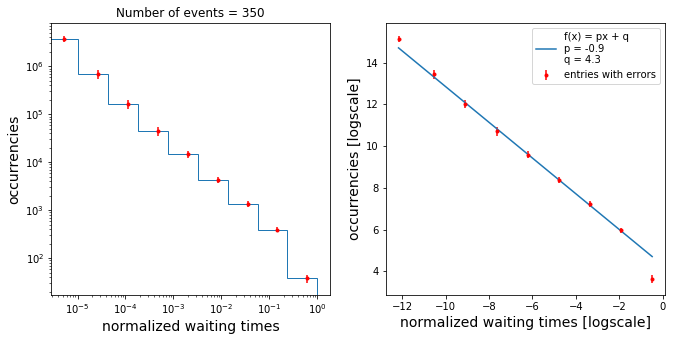

(-0.8558777519881158, 4.29408936863495, array([[0.00017896, 0.00111325],
        [0.00111325, 0.00839952]]), -1.1972120181777952)

In [51]:
plot_powerlaw_hist(time_d, rescaling = True, density = False, cut_off = True)

Bin extremes number chosen:  17
First quantile:  0.0002147493352317757
All frequencies are non-zero :  True
Good points 13 out of 16


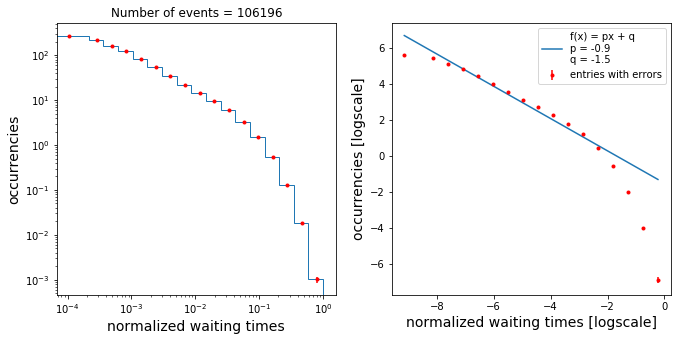

Bin extremes number chosen:  17
First quantile:  0.00013545672827580804
All frequencies are non-zero :  True
Good points 12 out of 16


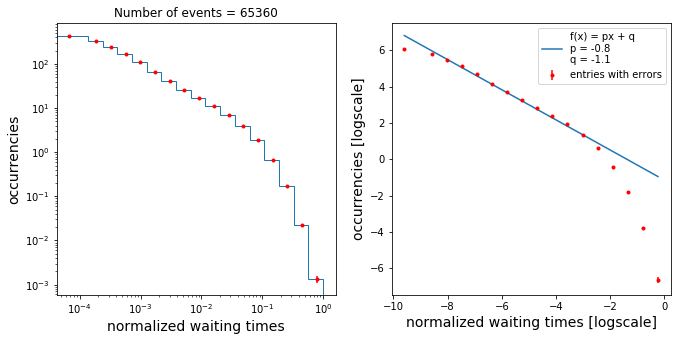

Bin extremes number chosen:  17
First quantile:  8.742791418310212e-05
All frequencies are non-zero :  True
Good points 13 out of 16


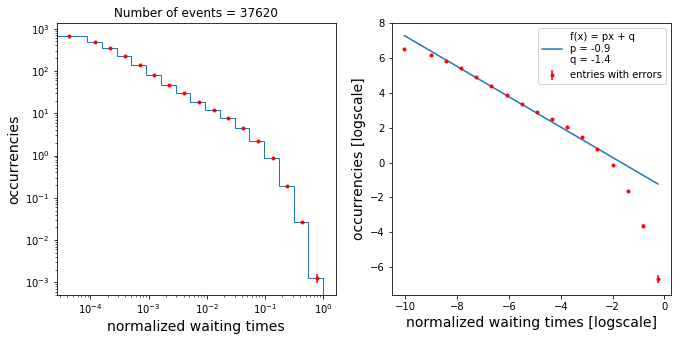

Bin extremes number chosen:  17
First quantile:  5.261189675180533e-05
All frequencies are non-zero :  True
Good points 13 out of 16


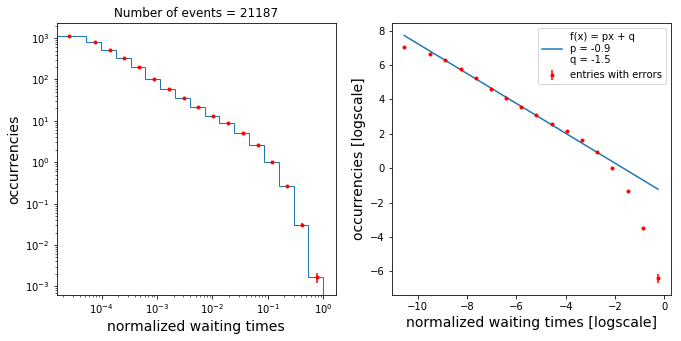

Bin extremes number chosen:  17
First quantile:  4.2888757395054944e-05
All frequencies are non-zero :  True
Good points 14 out of 16


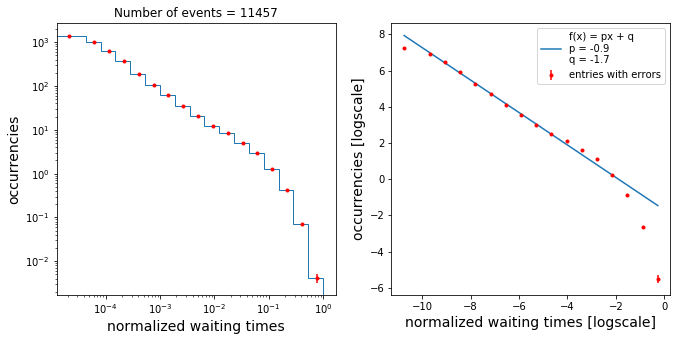

Bin extremes number chosen:  17
First quantile:  3.240839522626829e-05
All frequencies are non-zero :  True
Good points 14 out of 16


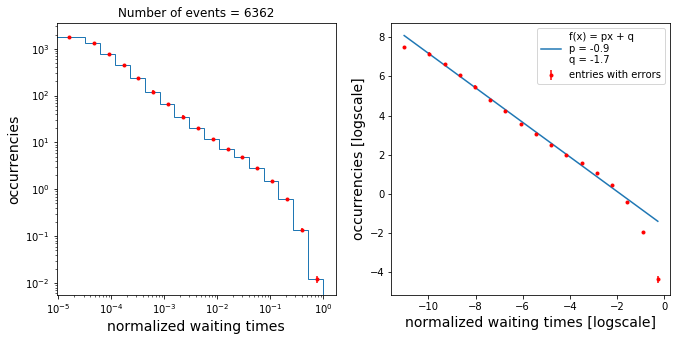

Bin extremes number chosen:  16
First quantile:  2.0046436782499255e-05
All frequencies are non-zero :  True
Good points 14 out of 15


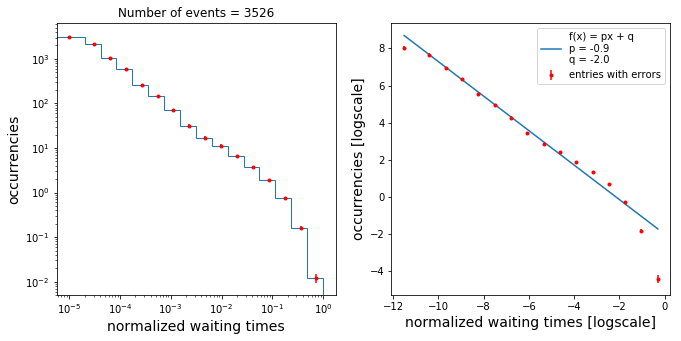

Bin extremes number chosen:  15
First quantile:  1.268138838341228e-05
All frequencies are non-zero :  True
Good points 13 out of 14


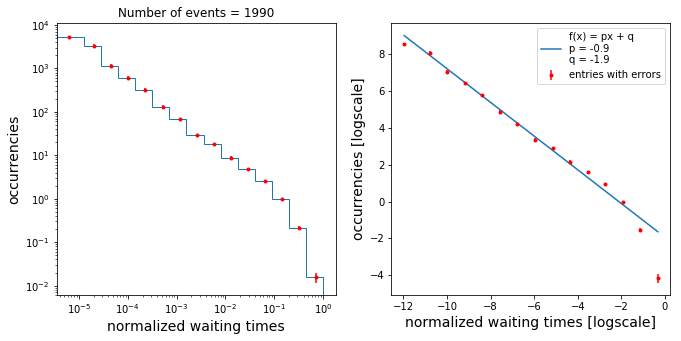

Bin extremes number chosen:  14
First quantile:  1.2747326479099159e-05
All frequencies are non-zero :  True
Good points 12 out of 13


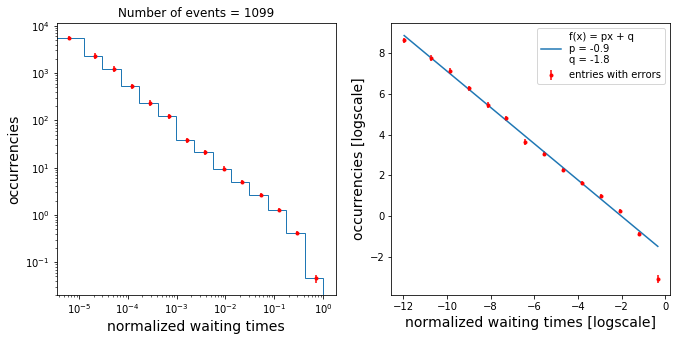

Bin extremes number chosen:  12
First quantile:  1.0562906549844495e-05
All frequencies are non-zero :  True
Good points 10 out of 11


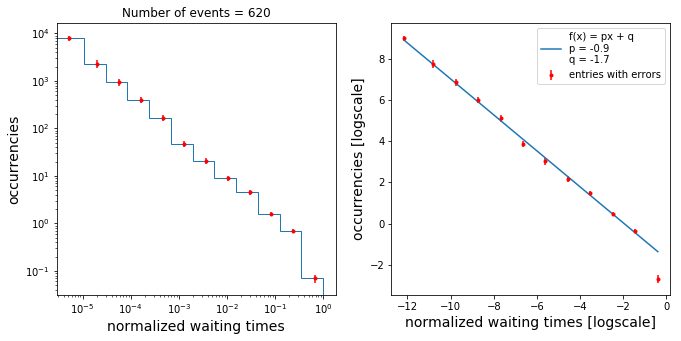

Bin extremes number chosen:  11
First quantile:  6.4940555570296375e-06
All frequencies are non-zero :  True
Good points 9 out of 10


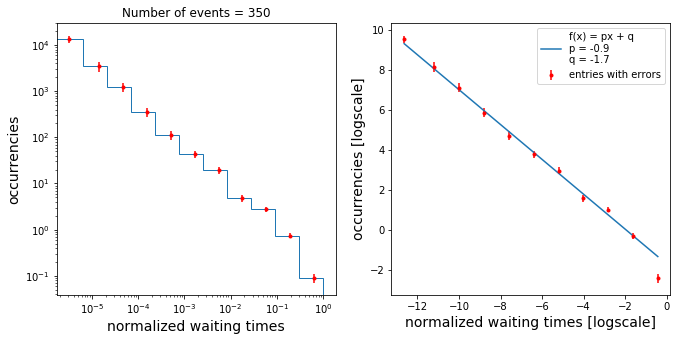

In [58]:
ms = np.linspace(2,4.5,11)

for i in range(len(ms)):
    m = ms[i]
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]

    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp
    plot_powerlaw_hist(time_d, rescaling = True, density = True, cut_off = True)